In [9]:
from ucimlrepo import fetch_ucirepo

# Fetch heart disease dataset
heart_disease = fetch_ucirepo(id=45)

# Data and target labels
X = heart_disease.data.features.values
y = heart_disease.data.targets.values


In [10]:

# Check the data types of the features
print(X.dtype)


float64


In [11]:
from sklearn.preprocessing import LabelEncoder

# If any features are categorical (string), encode them using Label Encoding
le = LabelEncoder()
for column in range(X.shape[1]):
    if isinstance(X[0, column], str):
        X[:, column] = le.fit_transform(X[:, column])


In [12]:
import pandas as pd

# Convert the features to a pandas DataFrame
X_df = pd.DataFrame(X)

# Check for missing values
print(X_df.isna().sum())  # This will show the count of missing values in each feature


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    4
12    2
dtype: int64


In [13]:
from sklearn.impute import SimpleImputer

# Initialize the imputer (using mean to fill missing values)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
X_imputed = imputer.fit_transform(X)

# Check if there are any remaining missing values
print(pd.DataFrame(X_imputed).isna().sum())


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64


In [14]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)

# Perform resampling after handling missing values (either imputed or dropped rows)
X_res, y_res = smote.fit_resample(X_imputed, y)




In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')  


# Function to train and evaluate model during cross-validation
def evaluate_model(model, X, y, cv):
    accuracies, f1_scores, auroc_scores = [], [], []
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        auroc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovr')
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
        auroc_scores.append(auroc)
    
    # Return average metrics
    return np.mean(accuracies), np.mean(f1_scores), np.mean(auroc_scores)

# List of models for comparison
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Stratified 10-fold cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Compare models and print results
for model_name, model in models.items():
    accuracy, f1, auroc = evaluate_model(model, X, y, cv)
    print(f"\n{model_name} - 10-fold CV Results:")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}")



Decision Tree - 10-fold CV Results:
Accuracy: 0.5017, F1 Score: 0.5033, AUROC: 0.6495

Random Forest - 10-fold CV Results:
Accuracy: 0.5513, F1 Score: 0.4971, AUROC: 0.8146

XGBoost - 10-fold CV Results:
Accuracy: 0.5576, F1 Score: 0.5318, AUROC: 0.7924


In [16]:
#comparison:
#XGBoost is the most accurate model (highest Accuracy and F1 Score).
#Random Forest performs the best in distinguishing between classes (highest AUROC).
#Decision Tree performs the weakest across all metrics, with the lowest Accuracy 

In [17]:


#Random Forest seems to be the best-performing model overall, with a strong AUROC score and solid accuracy.



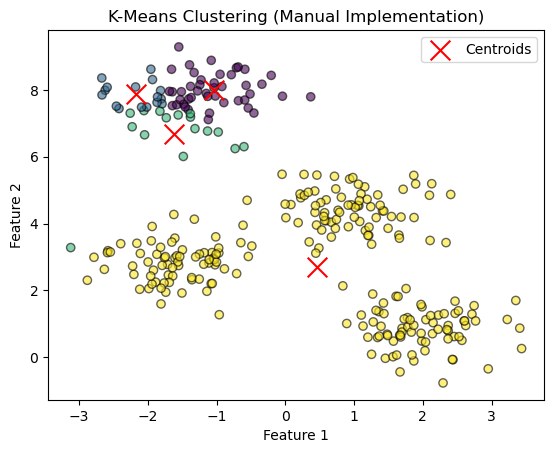

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic data (for demonstration)
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Function to implement K-means clustering 
def k_means(X, k, max_iters=300, tol=1e-4):
    # Randomly initialize centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    prev_centroids = centroids.copy()
    
    for i in range(max_iters):
        # Assign points to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Recalculate centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])
        
        # Check for convergence (if centroids don't change)
        if np.all(np.abs(new_centroids - prev_centroids) < tol):
            break
        
        prev_centroids = new_centroids.copy()
    
    return labels, new_centroids

# Apply the K-means algorithm
k = 4  # Number of clusters
labels, centroids = k_means(X, k)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolors='k', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='x', label='Centroids')
plt.title("K-Means Clustering (Manual Implementation)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


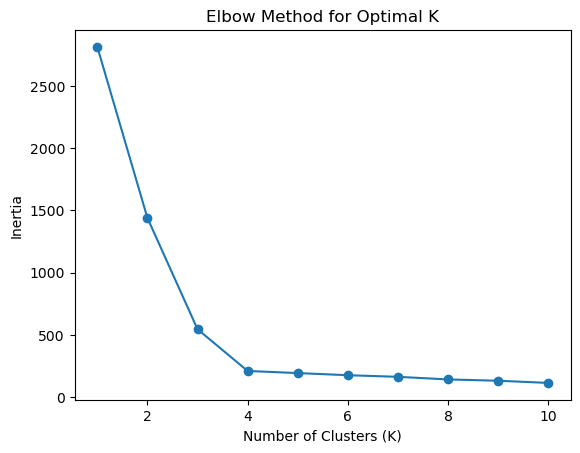

In [19]:
from sklearn.cluster import KMeans

# Function to compute inertia (sum of squared distances of samples to their closest cluster center)
def plot_elbow(X, max_k=10):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    # Plot the Elbow curve
    plt.plot(range(1, max_k + 1), inertia, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.show()

# Plot the elbow to estimate K
plot_elbow(X)


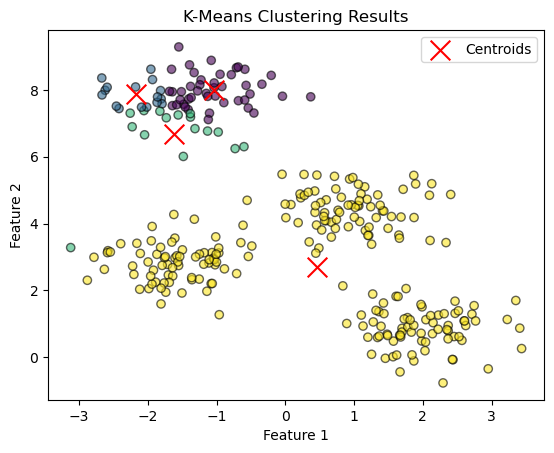

In [20]:

# Plotting K-means results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolors='k', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='x', label='Centroids')
plt.title("K-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


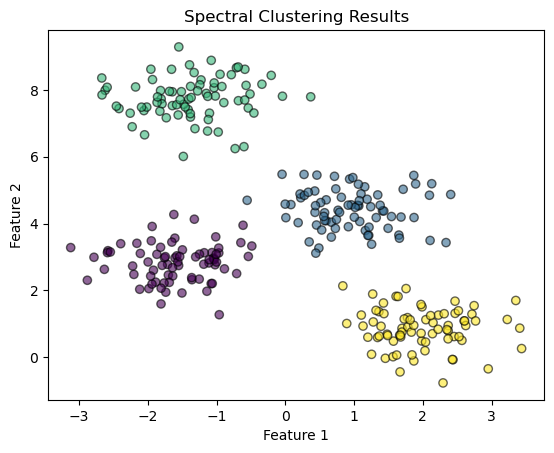

In [21]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering
spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=0)
labels_spectral = spectral.fit_predict(X)

# Plotting Spectral Clustering results
plt.scatter(X[:, 0], X[:, 1], c=labels_spectral, cmap='viridis', marker='o', edgecolors='k', alpha=0.6)
plt.title("Spectral Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
